In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
import tensorflow as tf 
 

In [2]:
# Définition du chemin du répertoire contenant les images
BASE_DIR = r'C:\Users\CBE\Desktop\extracted_files\UTKFace'
# Initialisation des listes pour stocker les étiquettes d'âge, de genre et les chemins des images
age_labels = []
gender_labels = []
image_paths = []
# Récupération de la liste des noms de fichiers dans le répertoire BASE_DIR
image_filenames = os.listdir(BASE_DIR)
# Mélange aléatoire de la liste des noms de fichiers
#random.shuffle(image_filenames)
# Boucle pour traiter chaque image dans la liste
for image in tqdm(image_filenames): #tqdm pour afficher une barre de progression
  image_path = os.path.join(BASE_DIR, image) 
  img_components = image.split('_') # Séparation du nom de l'image en ses composantes (âge et genre)
  age_label = int(img_components[0])   # Extraction de l'étiquette d'âge (première partie du nom de fichier) et conversion en entier
  gender_label = int(img_components[1]) # Extraction de l'étiquette de genre (deuxième partie du nom de fichier) et conversion en entier

    # Ajout du chemin de l'image, de l'étiquette d'âge et de l'étiquette de genre aux listes correspondantes
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [3]:
def image_generator(image_paths, age_labels, batch_size):
    while True:
        batch_indices = np.random.choice(len(image_paths), batch_size)
        batch_images = []
        batch_ages = []
        for idx in batch_indices:
            img = cv2.imread(image_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (200, 200))
            img_scaled = img_resized.astype('float32') / 255.0
            batch_images.append(img_scaled)
            batch_ages.append(age_labels[idx])
        yield np.array(batch_images), np.array(batch_ages)

batch_size = 32
train_generator = image_generator(image_paths, age_labels, batch_size=batch_size)
test_generator = image_generator(image_paths, age_labels, batch_size=batch_size)
# Diviser les données en ensembles d'entraînement et de test
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(image_paths , age_labels, random_state=42)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(image_paths , gender_labels, random_state=42)

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Charger le modèle VGG16 pré-entraîné sans les couches Dense à la fin
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Geler les couches de base pour éviter l'entraînement
for layer in base_model.layers:
    layer.trainable = False

# Créer un modèle séquentiel et ajouter les couches du modèle VGG16
age_model = Sequential()
age_model.add(base_model)

# Ajouter des couches supplémentaires personnalisées
age_model.add(Flatten())
age_model.add(Dense(512, activation='relu'))
age_model.add(Dropout(0.2))
age_model.add(Dense(1, activation='linear', name='age'))

# Compiler le modèle
age_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Afficher le résumé du modèle
print(age_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age (Dense)                     │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
history_age = age_model.fit(train_generator, validation_data=test_generator, epochs=50, steps_per_epoch=len(image_paths) // batch_size, validation_steps=len(image_paths) // batch_size)

#age_model.save('age_model_50epochs.h5') 

Epoch 1/10
 11/740 ━━━━━━━━━━━━━━━━━━━━ 1:57:15 10s/step - loss: 765.4526 - mae: 22.5795

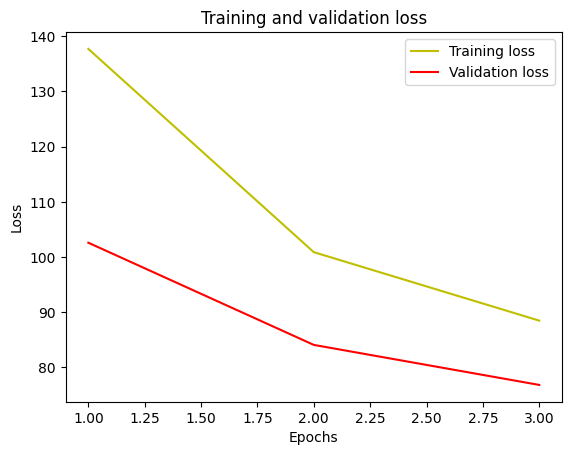

KeyError: 'accuracy'

In [22]:
history=history_age
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
age_model.save('age_model_50epochs.keras')
